<img src="images/cover.png" alt="Drawing" style="width: 1500px;"/>

In [1]:
%matplotlib inline

import statsmodels.api as sm
from datetime import datetime as dt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

bikeshare_train = pd.read_csv("train.csv", parse_dates=['datetime'])
bikeshare_test = pd.read_csv("test.csv", parse_dates=['datetime'])
df_test = bikeshare_test.copy()
df_train = bikeshare_train.copy()
dfy = df_train['count'].values
dfX = df_train.drop(columns=['casual', 'registered', 'count']).values
df_raw = bikeshare_train.copy()
df_train['count_log'] = df_train['count'].apply(lambda x: np.log(x))


# EDA : 누락 데이터 처리
def fill_zeros(df, column):
    df[column] = df[column].fillna(0)
    
    # mean : hour before and after
    idx1 = df[df[column] == 0].index.tolist()[1:]
    for i in idx1:    
        before = df[column][i - 1]
        after = df[column][i + 1]
        if before != 0 and after != 0:
            df[column][i] = round(np.mean([before, after]), 2)

    # mean : day before and after
    idx2 = df[df[column] == 0].index.tolist()
    for i in idx2:
        if df[column][i] <= 24:
            df[column][i] = df[column][i + 24]
        else:
            before = df[column][i - 24]
            after = df[column][i + 24]
            df[column][i] = round(np.mean([before, after]), 2)
    # mean : day mean
    idx3 = df[df[column] == 0].index.tolist()
    for i in idx3:
        day = df_train[[column]][24*(243//24) : 24*(243//24 + 1)]
        df[column][i] = day[day != 0].mean()

    return df[column]

df_train['windspeed'] = fill_zeros(df_train, 'windspeed')
df_train['humidity'] = fill_zeros(df_train, 'humidity')

# EDA : feature
def EDA_data(df):
    # parse datetime
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['year_month_day'] = df['datetime'].apply(lambda x: int(x.strftime('%y%m%d')))
    df['year_month'] = df['datetime'].apply(lambda x: int(x.strftime('%y%m')))
    df['month_day'] = df['datetime'].apply(lambda x: int(x.strftime('%m%d')))
    df['weekend'] = df['dayofweek'].apply(lambda x: 0 if x >= 5 else 1)
    
    
    # new season
    def season_div(df):
        if df['month_day'] >= 1121 or df['month_day'] <= 310:
            df['season'] = 3
        elif df['month_day'] >= 311 and df['month_day'] <= 520:
            df['season'] = 1
        elif df['month_day'] >= 521 and df['month_day'] <= 910:
            df['season'] = 2
        else:
            df['season'] = 1
        return df['season']
    df['season'] = df[['month_day','season']].apply(season_div, axis = 1)
    

    # new atemp
    def new_atemp(df):
        return 13.12 + 0.6215*float(df['temp']) - 11.37*(float(df["windspeed"])**0.16) + 0.3965*float(df["temp"])*(float(df["windspeed"])**0.16)
    df['atemp'] = df.apply(lambda df: new_atemp(df), axis= 1)
    


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 150)

EDA_data(df_train)
EDA_data(df_test)


# groupby 함수
def group_count(col, col1=None, count='count'):
    try:
        return df_train.groupby([col, col1]).sum()[count].reset_index()
    except:
        return df_train.groupby(col).sum()[count].reset_index()

# OLS 함수
def OLS_test(df, f):
    result = sm.OLS.from_formula(f, df).fit()
    return result

<img src="images/subtitle1.png" alt="Data Overview" style="width: 1500px;"/>

# About <`Bike Capital`>
- 2010년 9월에 서비스 시작(440 station, 3700 bike)
- 2011년 78만건, 2012년 130만건의 자전거가 대여된 규모있는 회사.

- 자전거의 대여방식은 4가지
> 30분간 대여 / 3시간 예약 / 1달 예약 / 1년 예약

# Purpose
---------------------------------------
* 다중회귀를 이용한 워싱턴DC 자전거 대여의 수요 예측
* Kaggle Competitions의 채점 방식인 Root Mean Squared Logarithmic Error (RMSLE)

# Data set
---------------------

> **Feature Data(9)**  
* `datetime` - hourly date + timestamp (2012-12-19 19:00:00)
* `season`   
  * 1 = spring   
  * 2 = summer  
  * 3 = fall  
  * 4 = winter    
* `holiday` - whether the day is considered a holiday  
* `workingday` - whether the day is neither a weekend nor holiday  
* `weather`     
  * 1: Clear, Few clouds, Partly cloudy, Partly cloudy   
  * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
  * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
  * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog    
* `temp` - temperature in Celsius   
* `atemp` - "feels like" temperature in Celsius  
* `humidity` - relative humidity  
* `windspeed` - wind speed  
  


> **Label Data(3)**  
* `casual` - number of non-registered user rentals initiated  
* `registered` - number of registered user rentals initiated  
* `count` - number of total rentals

In [2]:
df_raw.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


data size : 10885

- #### `training` dataset:
    - 매월 1일~19일
- #### `test` dataset:
    - 매월 20일~30/31일

<img src="images/subtitle2.png" alt="Conclusion" style="width: 1500px;"/>

# First Model
----

#### 테스트 퍼포먼스
> 채점 방식: Root Mean Squared Logarithmic Error (RMSLE).

![worst performance](images/k_worst.png)

# Best Model
----
> 1471등/3251명 (상위 45%)

![best performance](images/k_best.png)

In [3]:
f = 'np.log(count + 2) ~ C(hour):C(weekend)/scale(atemp) + C(month)*scale(humidity) + C(weather) + scale(windspeed)'
train_result = OLS_test(df_train, f)
train_result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(count + 2)   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     950.4
Date:                Thu, 16 May 2019   Prob (F-statistic):               0.00
Time:                        18:30:43   Log-Likelihood:                -5439.0
No. Observations:               10886   AIC:                         1.112e+04
Df Residuals:                   10763   BIC:                         1.202e+04
Df Model:                         122                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  4.1988      0.041    102.795      0.000       4.119       4.279
C(month)[T.2]                              0.1890      0.020      9.432      0.000       0.150       0.228
C(month)[T.3]                              0.1967      0.021      9.398      0.000       0.156       0.238
C(month)[T.4]                              0.3045      0.022     13.697      0.000       0.261       0.348
C(month)[T.5]                              0.5384      0.025     21.408      0.000       0.489       0.588
C(month)[T.6]                              0.4080      0.028     14.437      0.000       0.353       0.463
C(month)[T.7]                              0.2730      0.032      8.652      0.000       0.211       0.335
C(month)[T.8]                              0.3059      0.031      9.963      0.000       0.246       0.366
C(month)[T.9]                              0.5365      0.028     19.064      0.000       0.481       0.592
C(month)[T.10]                             0.6617      0.024     27.364      0.000       0.614       0.709
C(month)[T.11]                             0.6503      0.021     31.691      0.000       0.610       0.691
C(month)[T.12]                             0.6270      0.021     30.433      0.000       0.587       0.667
C(weather)[T.2]                           -0.0402      0.010     -4.176      0.000      -0.059      -0.021
C(weather)[T.3]                           -0.4732      0.016    -28.773      0.000      -0.505      -0.441
C(weather)[T.4]                           -0.0325      0.404     -0.080      0.936      -0.825       0.760
C(weekend)[T.1]                           -0.9698      0.042    -22.968      0.000      -1.053      -0.887
C(hour)[T.1]:C(weekend)[0]                -0.2208      0.051     -4.351      0.000      -0.320      -0.121
C(hour)[T.2]:C(weekend)[0]                -0.4752      0.051     -9.297      0.000      -0.575      -0.375
C(hour)[T.3]:C(weekend)[0]                -1.1774      0.051    -22.959      0.000      -1.278      -1.077
C(hour)[T.4]:C(weekend)[0]                -2.1678      0.052    -41.928      0.000      -2.269      -2.066
C(hour)[T.5]:C(weekend)[0]                -2.1547      0.052    -41.304      0.000      -2.257      -2.052
C(hour)[T.6]:C(weekend)[0]                -1.5770      0.052    -30.172      0.000      -1.679      -1.475
C(hour)[T.7]:C(weekend)[0]                -0.7916      0.052    -15.296      0.000      -0.893      -0.690
C(hour)[T.8]:C(weekend)[0]                 0.0338      0.051      0.664      0.506      -0.066       0.133
C(hour)[T.9]:C(weekend)[0]                 0.5215      0.050     10.374      0.000       0.423       0.620
C(hour)[T.10]:C(weekend)[0]                0.8932      0.050     17.851      0.000     

# Major Insight
----

#### Major Insight
> - 2011년보다 2012년에 성장
> - 매월 증가 추세
> - 봄, 가을에 대여량 ↑
> - `humidity`와 `windspeed`가 일정 이상이면 대여량 ↓
> - `casual`이 `registered`보다 날씨 등 외부 요인에 영향 ↑
> - `hour`, `,weekend`, `atemp` 간의 교호작용
> - `month`, `humidity` 간의 교호작용
> - 출퇴근 시간에 대여량 ↑

#### Hour by week&weekend
> - 주말과 평일에 형태가 다르다.
> - 평일에는 출퇴근시간대에 많이 빌리고, 주말에는 오후 시간에 수요가 많다는 insight를 얻었다.

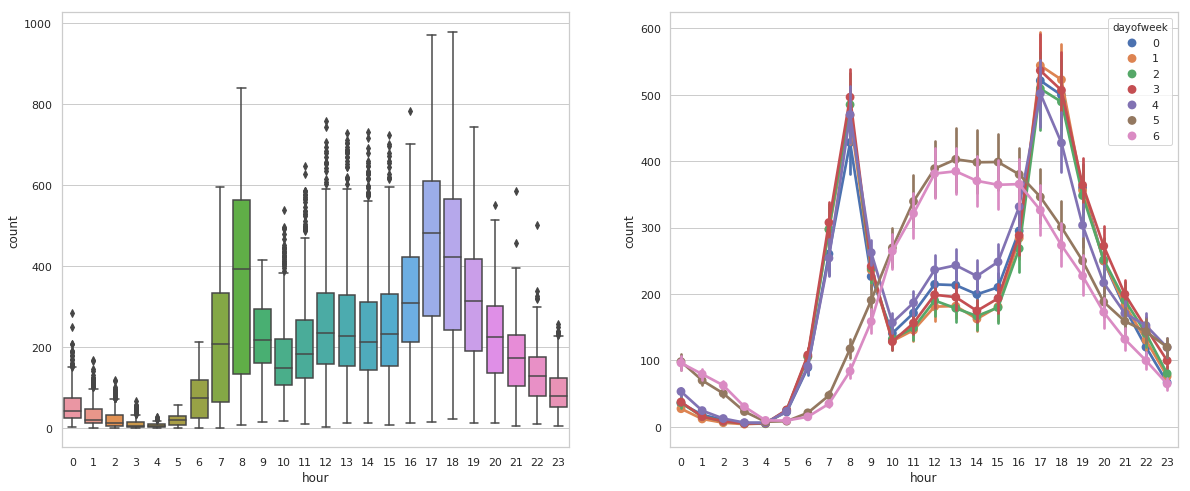

In [4]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sns.boxplot(x="hour", y="count", data=df_train)

plt.subplot(122)
sns.pointplot(data=df_train,x='hour',y='count',hue='dayofweek')

<img src="images/subtitle3.png" alt="Main Subject" style="width: 1500px;"/>

# 1. Data Exploration
-----

### 1) 데이터 관계 파악
> - atemp, temp 다중공선성 발생(drop temp)
> - 독립변수(연속변수)와 종속변수(count)의 선형관계 찾기 어려움(*카테고리별 추가 필요함)

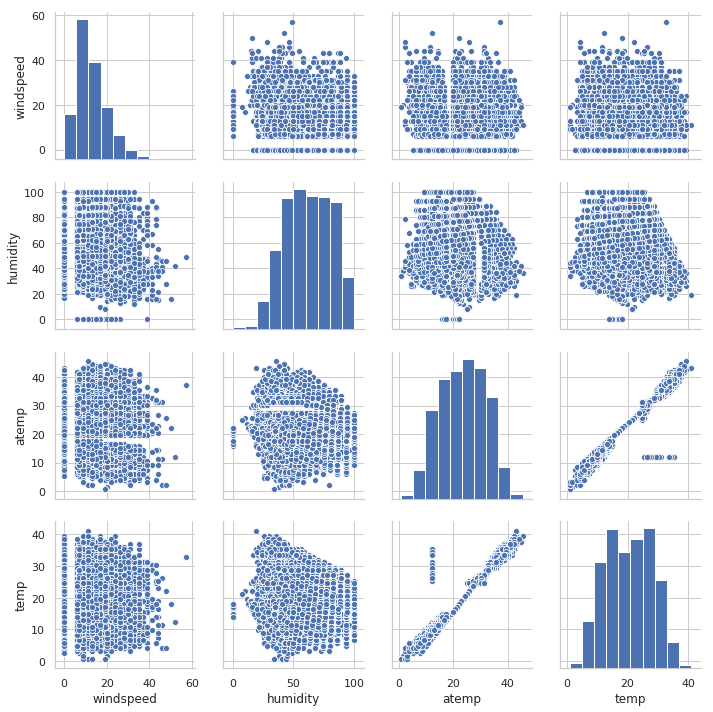

In [5]:
numerical = df_raw[['windspeed', 'humidity', 'atemp', 'temp']]
sns.pairplot(data=numerical)
plt.show()

### 2) 주요 EDA (연속변수: windspeed, attemp, humidity)

> #### ① humidity
- 이상치: 2011.3.10 데이터 0
- 해결
    - 날씨 사이트에서 해당 날짜의 humidity의 평균 입력

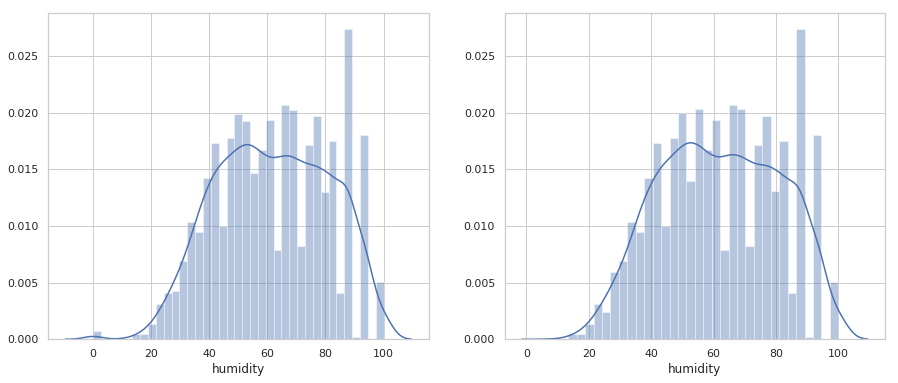

In [6]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
sns.distplot(df_raw['humidity'])
plt.subplot(122)
sns.distplot(df_train['humidity'])
plt.show()

> #### ② windspeed
- 이상치: 0
- 해결
    - 앞뒤 한 시간의 평균치 
    - 해당 날짜의 풍속 평균치

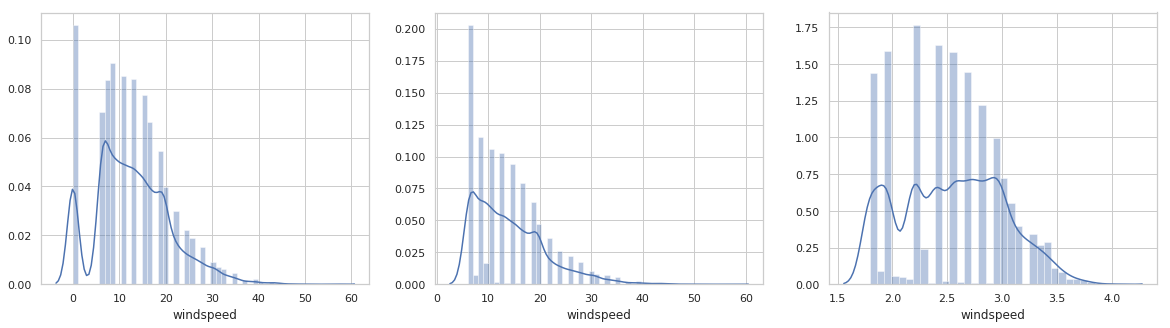

In [7]:
plt.figure(figsize=(20, 5))
plt.subplot(131)
sns.distplot(df_raw['windspeed'])
plt.subplot(132)
sns.distplot(df_train['windspeed'])
plt.subplot(133)
sns.distplot(np.log(df_train['windspeed']))

> #### ③ atemp

In [8]:
# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(numerical[numerical.columns].values, i)\
                                                      for i in range(numerical[numerical.columns].shape[1])]
vif["features"] = numerical[numerical.columns].columns
vif

,VIF Factor,features
0,2.717068,windspeed
1,5.749326,humidity
2,285.638206,atemp
3,263.585580,temp


In [9]:
# VIF: temp제거
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(numerical[numerical.columns[:-1]].values, i)\
                                                      for i in range(numerical[numerical.columns[:-1]].shape[1])]
vif["features"] = numerical[numerical.columns[:-1]].columns
vif

,VIF Factor,features
0,2.687013,windspeed
1,5.200188,humidity
2,5.801852,atemp


> - 이상치: 12개 데이터 '12.12'도 입력
> - 해결
>    - 체감온도 공식 사용하여 입력(`T` : temp / `V` : windspeed)
----
$$ atemp = 13.12 + 0.6215 \cdot T - 11.37 \cdot V^{0.16} + 0.3965 \cdot T \cdot V^{0.16} $$

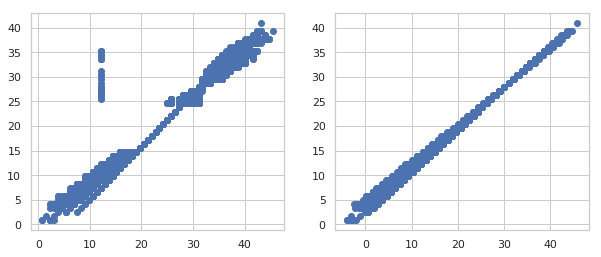

In [12]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.scatter(x='atemp', y='temp', data=df_raw)
plt.subplot(122)
plt.scatter(x='atemp', y='temp', data=df_train)
plt.show()

### 3) 상관관계
> - atemp와 temp 상관관계 높음(*atemp 누락)

> #### ① correlation

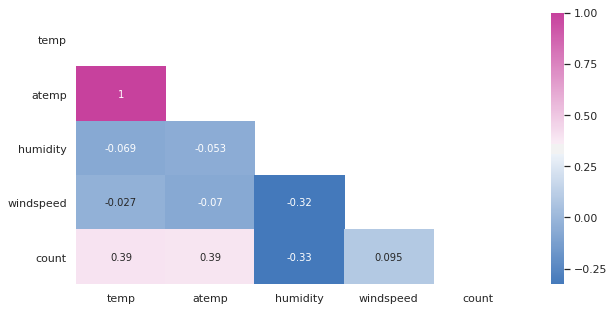

In [13]:
plt.figure(figsize=(10, 5))
vif = pd.DataFrame()
numerical = df_train[['temp', 'atemp', 'humidity', 'windspeed', 'count']]
cor_mat = numerical.corr()
mask = np.zeros_like(cor_mat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(250, 330, as_cmap=True)
sns.heatmap(data=cor_mat, mask=mask, annot=True,cmap=cmap)
plt.show()

> #### ② VIF

In [14]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(numerical[numerical.columns[1:-1]].values, i)\
                                                      for i in range(numerical[numerical.columns[1:-1]].shape[1])]
vif["features"] = numerical[numerical.columns[1:-1]].columns
vif

,VIF Factor,features
0,4.381724,atemp
1,4.671573,humidity
2,3.367936,windspeed


> ### 4) 카테고리별 독립성

In [15]:
def chi2_test(df = df_train, cat1='hour', cat2='holiday', values='count'):
        """
        params: dataframe, 범주형 컬럼명1, 범주형 컬럼명2, 값
        귀무가설: 범주1, 2는 독립이다.
        return: g 카이제곱값, p p-value
        """
        chi2_df = df.pivot_table(values=values, index=cat1, columns=cat2, aggfunc=np.mean, fill_value=0)
        g, p, dof, expected = sp.stats.chi2_contingency(chi2_df)    
        return p
    
def cate_cor(*cols):
    col = list(cols)
    df = pd.DataFrame(columns=col, index=col)
    ls = []
    for i in col:
        for j in col:
            if i == j:
                ls.append(0)
            else:
                ls.append(chi2_test(cat1 = i, cat2 = j))
        df[i] = ls
        ls = []
        
    return df
    
indep = cate_cor('hour', 'weekend', 'month', 'weather', 'season')

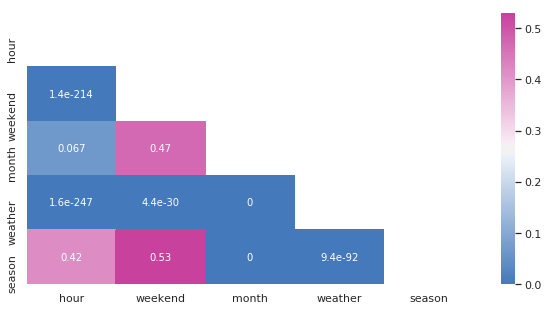

In [16]:
plt.figure(figsize=(10, 5))
cmap = sns.diverging_palette(250, 330, as_cmap=True)
sns.heatmap(data=indep, mask=mask, annot=True, cmap=cmap)
plt.show()

# 모델구축
----
> formula  = 'np.log(count + 2) ~ 0 + C(hour):C(weekend)/scale(atemp) + C(month)*scale(humidity) + C(weather) + scale(windspeed)'

In [17]:
f_raw = 'count ~ C(hour) + scale(atemp) + scale(humidity) + I(scale(windspeed)**3) + C(year) + C(season) + C(workingday)'
raw_result = OLS_test(df_train, f_raw)

<img src="images/subtitle4.png" alt="Diagnosis" style="width: 1500px;"/>

# Diagnosis of Final Model
----

In [18]:
scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=0)
df_rsq = pd.DataFrame(columns=["Training R2", "Test R2"])

for i, (idx_train, idx_test) in enumerate(cv.split(df_train)):
    df_train1 = df_train.iloc[idx_train]
    df_test1 = df_train.iloc[idx_test]
    
    f = 'np.log(count + 2) ~ 0 + C(hour):C(weekend)/scale(atemp) + C(month)*scale(humidity) + C(weather)'
    model = sm.OLS.from_formula(f, data=df_train)
    result = model.fit()

    pred = np.exp(result.predict(df_test1)) + 2
    rss = ((df_test1['count'] - pred) ** 2).sum()
    tss = ((df_test1['count'] - df_test1["count"].mean())** 2).sum()
    rsquared = 1 - (rss / tss)
    

    scores[i] = rsquared

    df_rsq.loc[i] = [result.rsquared, rsquared]

df_rsq.index +=1

> ### 1) 과적합(K-fold Cross Validation)

In [19]:
df_rsq

,Training R2,Test R2
1,0.914429,0.818900
2,0.914429,0.794355
3,0.914429,0.821552
4,0.914429,0.828315
5,0.914429,0.831212


> ### 2) 정규성(QQ plot, Omnibus test)

In [20]:
pred = (np.exp(train_result.predict(df_train))-2)**1.01

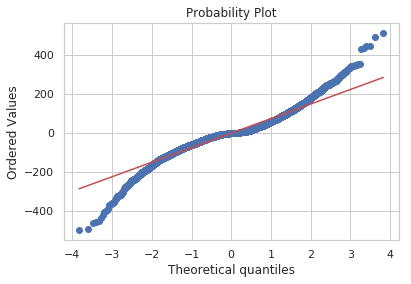

In [21]:
# QQ플롯
sp.stats.probplot(dfy - pred, plot=plt)
plt.show()

In [22]:
## 정규성 테스트
test = sm.stats.omni_normtest(dfy - pred)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.1f" % xi)

Chi^2       : 1052.7
P-value     :    0.0


> ### 3) 등분산성(종속변수 변환)

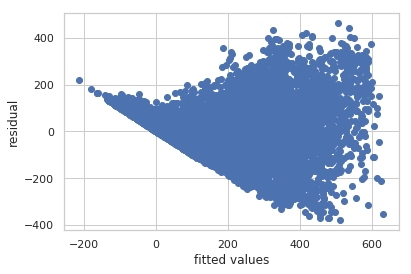

In [23]:
# 이분산성을 보임
plt.scatter(x=raw_result.fittedvalues, y=raw_result.resid)
plt.xlabel("fitted values")
plt.ylabel("residual")
plt.show()

> - 종속변수 로그변환 후 이분산성이 조금 완화되었다.

Text(0, 0.5, 'residuals')

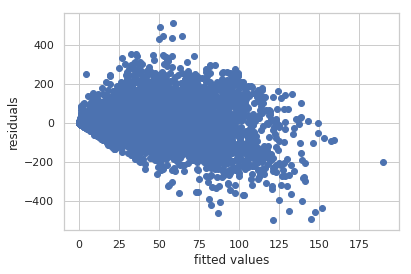

In [24]:
# 이분산 문제 조금 더 괜찮아짐
plt.scatter((np.exp(train_result.fittedvalues-2))**1.05, df_train['count'] - pred)
plt.xlabel('fitted values')
plt.ylabel('residuals')

> ### 4) 적합성 여부(독립변수 vs 예측치)

> - y와 y hat 간에 로그함수 관계가 보인다.

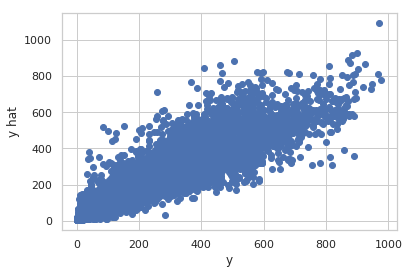

In [29]:
# y와 y hat 간에 로그함수 관계가 보임
plt.scatter(x=df_train['count'], y=np.exp(train_result.fittedvalues))
plt.xlabel('y')
plt.ylabel('y hat')
plt.show()

> - log 변환 후, y와 y hat 간에 선형관계 보인다.

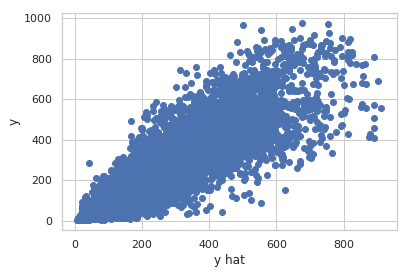

In [88]:
plt.scatter(x=pred, y=dfy)
plt.xlabel('y hat')
plt.ylabel('y')
plt.show()

# 미해결 과제
----

> 1. 정규성 문제
> 2. 이분산성 문제
> 3. `casual`과 `register`의 분포가 상이하고, feature 변수들과의 영향력이 다른 점

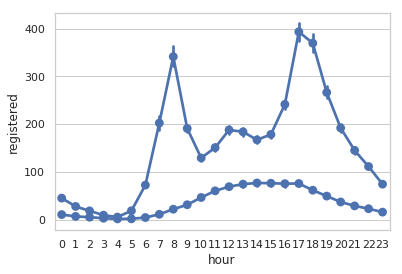

In [89]:
sns.pointplot(data=df_train, x='hour',y='casual')
sns.pointplot(data=df_train, x='hour', y='registered')

> 회원과 비회원이 빌리는 형태가 다르다.(사용하는 사람들의 형태가 다르다고 해석된다.)